# Extract blue lines from PZ cube

Mainly Hβ, He II, He I, [O III], [Ar IV], [N I], Si II

## Library imports and data loading

Copied from the `02-01-Raman-Wings-IR-Source-C` notebook:

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import regions
import sys
from whispy import moments
from whispy import extract

sns.set_context("talk")
sns.set_color_codes()

In [2]:
moments.FIGPATH = Path("../../figs")
moments.SAVEPATH = Path("../../data")

We only have the coadded version of the Peter cube, so the seeing is a bit worse than in the sharp ESO cube

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "PeterZeidler" / "DATACUBE_FINAL_fwhm_cor.fits"
cube = Cube(str(fitsfilepath))

## Use moments to extract the Hβ line and other blue lines

Use a generic name for the cube over the broad wavelength range to reduce need for edits when we repurpose this later.

In [4]:
wavmin, wavmax = 4600, 5400

Only one cube available (unlike with the pipeline ESO version), so I am removing all reference to `mcube`

In [5]:
cube = cube.select_lambda(wavmin, wavmax)

In [6]:
# Position of mYSO
x, y = 116, 147
# position of B0 star SSN 43
xb, yb = 95, 163
# position of B0 star SSN 40
xbb, ybb = 121, 133
m = 3

boxes = {
    "SSN 152+168": regions.BoundingBox(
        iymin=y - m,
        iymax=y + m,
        ixmin=x - m,
        ixmax=x + m,
    ),
    #    "BG 152+168": regions.BoundingBox(
    #        iymin=y-2*m, iymax=y+2*m, ixmin=x-2*m, ixmax=x+2*m,
    #    ),
    "SSN 43": regions.BoundingBox(
        iymin=yb - m,
        iymax=yb + m,
        ixmin=xb - m,
        ixmax=xb + m,
    ),
    #    "BG 43": regions.BoundingBox(
    #        iymin=yb-2*m, iymax=yb+2*m, ixmin=xb-2*m, ixmax=xb+2*m,
    #    ),
    "SSN 40": regions.BoundingBox(
        iymin=ybb - m,
        iymax=ybb + m,
        ixmin=xbb - m,
        ixmax=xbb + m,
    ),
    #    "BG 40": regions.BoundingBox(
    #        iymin=ybb-2*m, iymax=ybb+2*m, ixmin=xbb-2*m, ixmax=xbb+2*m,
    #    ),
    "blue": regions.BoundingBox(iymin=75, iymax=140, ixmin=15, ixmax=40),
    "red": regions.BoundingBox(iymin=200, iymax=250, ixmin=210, ixmax=300),
    "magenta": regions.BoundingBox(iymin=10, iymax=50, ixmin=100, ixmax=150),
    "green": regions.BoundingBox(iymin=10, iymax=100, ixmin=200, ixmax=300),
    "cyan": regions.BoundingBox(iymin=170, iymax=210, ixmin=90, ixmax=120),
}


These are the ranges that the continum is fitted to. It is OK if they contain some weak lines.

In [7]:
wavranges = [
    (4600, 4620),
    (4720, 4730),
    (4760, 4800),
    (4937, 4947),
    (4974, 4984),
    (5028, 5038),
    (5070, 5100),
    (5120, 5145),
    (5220, 5260),
    (5330, 5390),
]

        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]


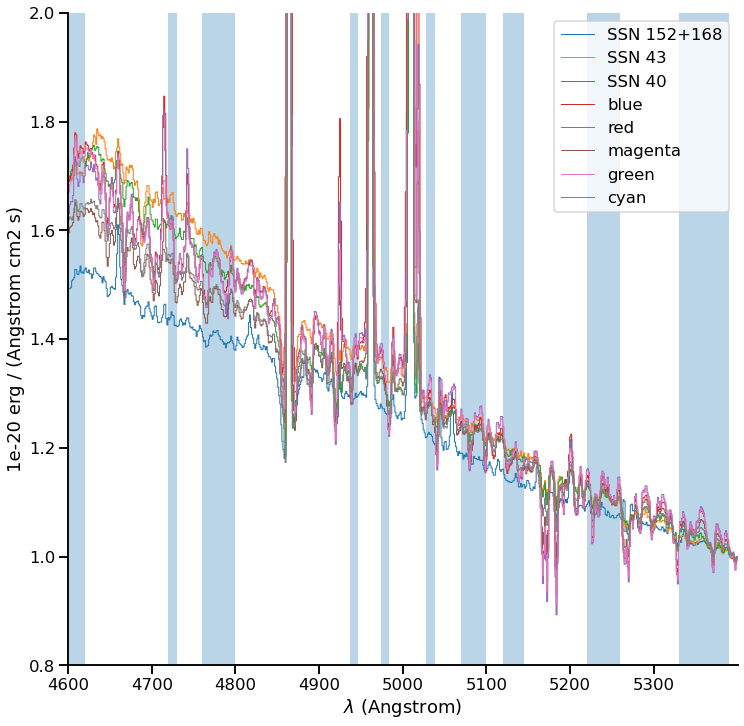

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
for label, box in boxes.items():
    yslice, xslice = box.slices
    spec = cube[:, yslice, xslice].mean(axis=(1, 2))
    (spec / spec.data[-1]).plot(label=label)

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.legend()
ax.set(
    ylim=[0.8, 2.0],
)
sns.despine()

There does seem a lot more structure in the "continuum" bands, as compared with the ESO cubes. Hopefully, this will not be too much of an issue. 

In [9]:
yslice, xslice = boxes["SSN 152+168"].slices
subcube = cube[:, yslice, xslice]
contcube = extract.fit_continuum(
    subcube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

extract.fit_continuum: row 0


        Use get_overlap_slices instead. [warnings]


[(2000.0, 5000.0)]

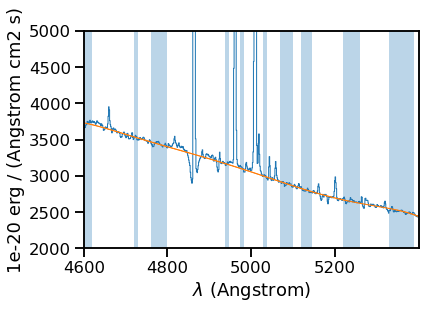

In [10]:
fig, ax = plt.subplots()
subcube.mean(axis=(1, 2)).plot()
contcube.mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[2000, 5000])

In [11]:
yslice, xslice = boxes["green"].slices
subcube = cube[:, yslice, xslice]
contcube = extract.fit_continuum(
    subcube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

        Use get_overlap_slices instead. [warnings]


extract.fit_continuum: row 0
extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80


[(0.0, 180.0)]

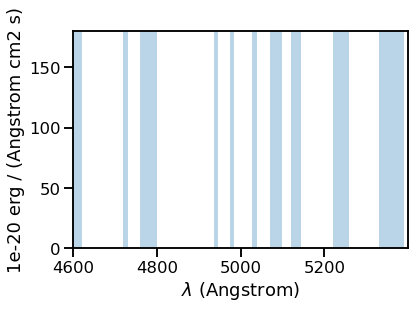

In [12]:
fig, ax = plt.subplots()
subcube.mean(axis=(1, 2)).plot()
contcube.mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[0, 180])

So it turns out that a high order polynomial is needed because of the broad wavelength range.  And it is better to use the full set of points rather than the median *and* that is faster too!

Calculating the median must be expensive.

In [13]:
contcube = extract.fit_continuum(
    cube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:300: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:368: RuntimeWarning: invalid value encountered in add
  return off + scl*x
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110
extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]


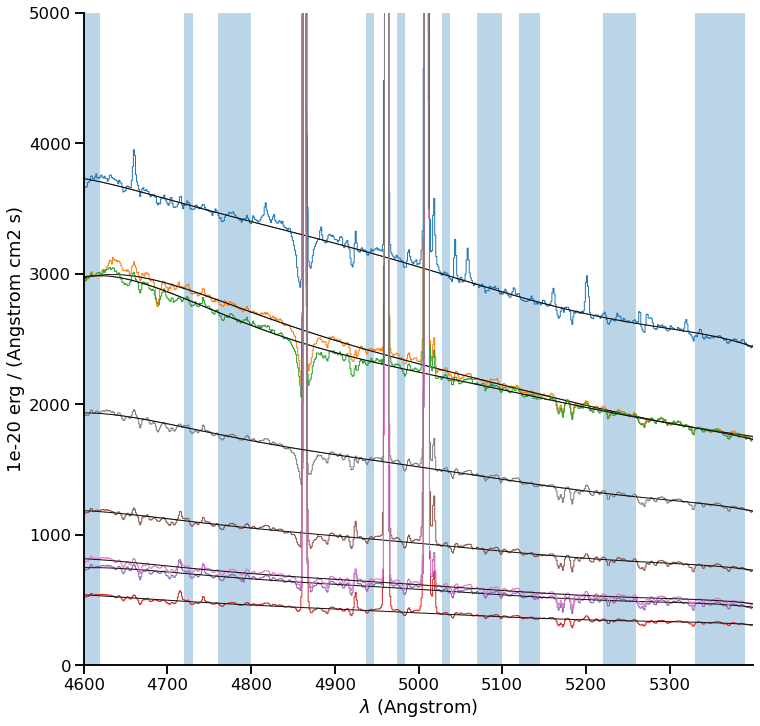

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
for box in boxes.values():
    yslice, xslice = box.slices
    spec = cube[:, yslice, xslice].mean(axis=(1, 2))
    cspec = contcube[:, yslice, xslice].mean(axis=(1, 2))
    spec.plot()
    cspec.plot(color="k")

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(
    ylim=[0, 5000],
)
sns.despine()

In [15]:
prefix = f"../../big-data/ngc346-PZ-{wavmin:d}-{wavmax:d}-cube"
prefix

'../../big-data/ngc346-PZ-4600-5400-cube'

In [16]:
csubcube = cube - contcube
cdivcube = cube / contcube

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [17]:
csubcube.write(
    f"{prefix}-contsub.fits",
    savemask="nan",
)
cdivcube.write(
    f"{prefix}-contdiv.fits",
    savemask="nan",
)
contcube.write(
    f"{prefix}-cont.fits",
    savemask="nan",
)

## Inspect the blue spectrum

Compare bow shock to median of cube

In [18]:
mboxes = {
    "sw filament": regions.BoundingBox(
        iymin=30,
        iymax=50,
        ixmin=300,
        ixmax=330,
    ),
    "bow shock": regions.BoundingBox(
        iymin=165,
        iymax=205,
        ixmin=240,
        ixmax=290,
    ),
    "w filament": regions.BoundingBox(
        iymin=100,
        iymax=130,
        ixmin=25,
        ixmax=55,
    ),
    "c filament": regions.BoundingBox(
        iymin=195,
        iymax=210,
        ixmin=155,
        ixmax=195,
    ),
}

In [20]:
yslice, xslice = mboxes["bow shock"].slices
bowspec_sub = csubcube[:, yslice, xslice].mean(axis=(1, 2))

avspec_sub = csubcube.mean(axis=(1, 2))
medspec_sub = csubcube.median(axis=(1, 2))

        Use get_overlap_slices instead. [warnings]


In [21]:
lowspec_sub = medspec_sub.copy()
lowspec_sub.data = np.percentile(csubcube.data, 25, axis=(1, 2))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [22]:
nobs_subcube = csubcube.data.copy()
nobs_subcube[:, yslice, xslice] = np.nan
nobs_medspec_sub = medspec_sub.copy()
nobs_medspec_sub.data = np.nanmedian(nobs_subcube, axis=(1, 2))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:3823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


In [23]:
hi_wavs = [4641.81, 4650.00, 4685.71, 4711.37, 4740.17]
med_wavs = [4658.10, 4701.62, 4713.14, 4861.32, 4921.93, 4931.32]

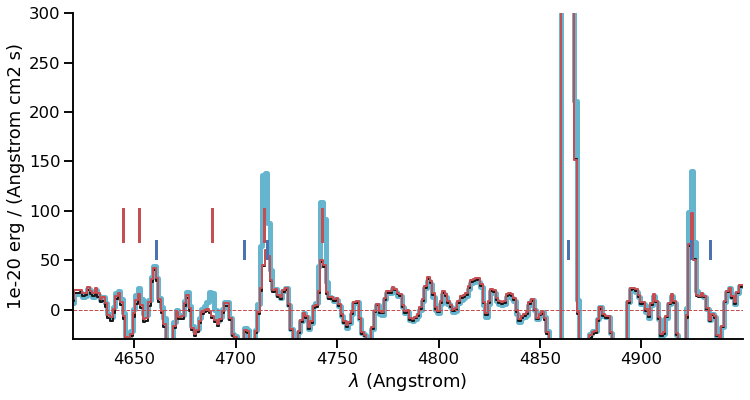

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 4620, 4950
(bowspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
(nobs_medspec_sub).subspec(wav1, wav2).plot(color="r", linewidth=2)
for wav in hi_wavs:
    ax.axvline(
        wav * (1.0 + 160.0 / 3e5), ymin=0.3, ymax=0.4, color="r", linewidth=3, alpha=1.0
    )
for wav in med_wavs:
    ax.axvline(
        wav * (1.0 + 160.0 / 3e5),
        ymin=0.25,
        ymax=0.3,
        color="b",
        linewidth=3,
        alpha=1.0,
    )
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-30, 300],
)
sns.despine()
fig.savefig(moments.FIGPATH / f"ngc346-bow-shock-BZ-spec-{wav1}-{wav2}.pdf")

These are a lot harder to see than in the ESO cube, unfortunately. In following cells I will experiment with subtracting a median (or other percentile) spectrum. In the meantime, these are the original line IDs.

Left to right:

* 4641, 4650: could be O II lines? seen from bow shock only, but weird if true
* 4658 [Fe III] BG only
* 4686 He II - bow shock only
* 4713 [Fe III] BG only (very weak)
* 4711+13 [Ar IV] + He I (and could also include [Ne IV] 4714, except that 4725 is not seen)
* 4740 [Ar IV]
* 4861 H beta
* 4921.93 He I
* 4931.32 [O III] - the very weak component of the triplet

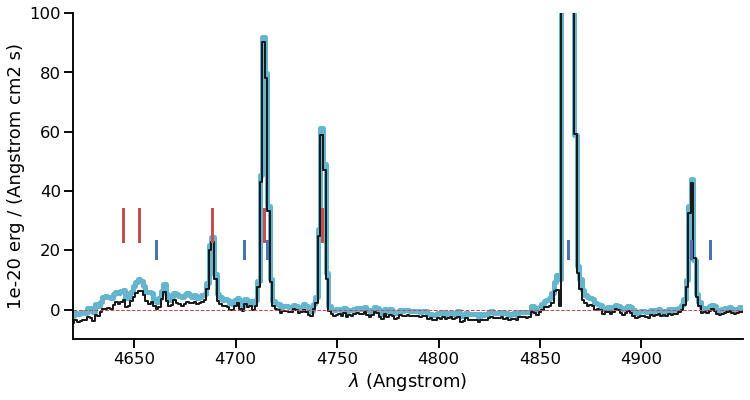

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 4620, 4950
(bowspec_sub - medspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(bowspec_sub - nobs_medspec_sub).subspec(wav1, wav2).plot(
    linewidth=2, color='k', alpha=1.0)
for wav in hi_wavs:
    ax.axvline(
        wav * (1.0 + 160.0 / 3e5), ymin=0.3, ymax=0.4, color="r", linewidth=3, alpha=1.0
    )
for wav in med_wavs:
    ax.axvline(
        wav * (1.0 + 160.0 / 3e5),
        ymin=0.25,
        ymax=0.3,
        color="b",
        linewidth=3,
        alpha=1.0,
    )
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-10, 100],
)
sns.despine()
fig.savefig(moments.FIGPATH / f"ngc346-bow-shock-BZ-medsub-spec-{wav1}-{wav2}.pdf")

Subtracting the median gives much better results (blue line). 

I had experimented with using a lower quartile than the median for subtracting, but that was worse. I also tries doing the median over only the non-bowshock parts ogf the map, but that makes hardly any difference (black line).


The long wavelength side of the strong [O III] lines is less interesting:

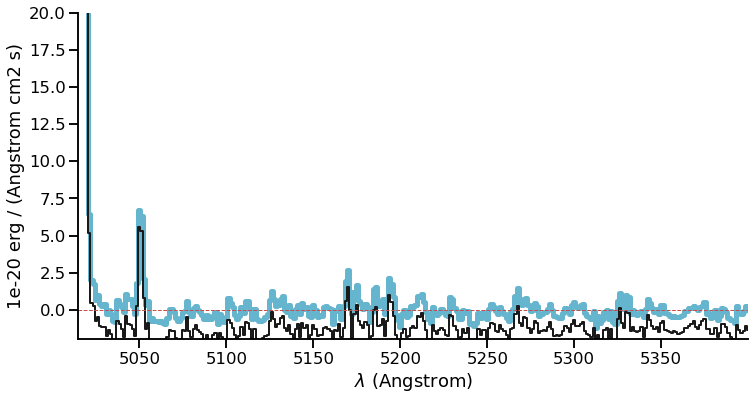

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 5015, 5400
(bowspec_sub - medspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(bowspec_sub - nobs_medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-2, 20],
)
sns.despine()

He I line at 5047.74 and [Ar III] line at 5193.69

## Extract He II line

In [27]:
mom4686 = moments.find_moments(csubcube.select_lambda(4686, 4691))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


In [28]:
dlam, _, _ = cube.get_step()
cont4686 = contcube.select_lambda(4686, 4691).mean(axis=0)
ew4686 = dlam * mom4686[0] / cont4686

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [29]:
cont4686.write(moments.SAVEPATH / "ngc346-BZ-cont-4686-mean.fits", savemask="nan")
ew4686.write(moments.SAVEPATH / "ngc346-BZ-ew-4686-mean.fits", savemask="nan")

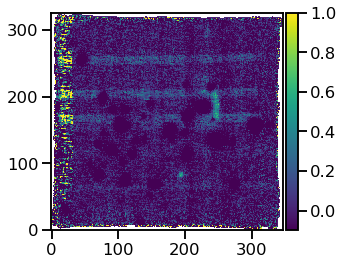

In [30]:
ew4686.plot(vmin=-0.1, vmax=1, colorbar="v")

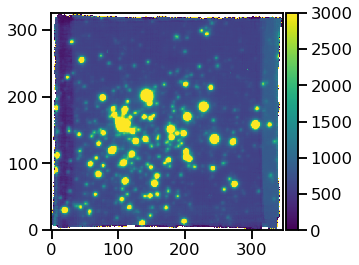

In [31]:
cont4686.plot(vmin=0, vmax=3000, colorbar="v")

In [32]:
mom4686[0].mask = mom4686[0].mask | (cont4686.data > 5000)

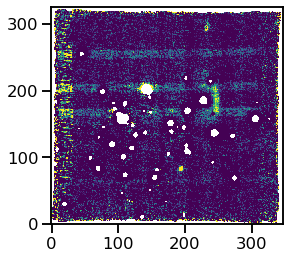

In [33]:
mom4686[0].rebin(1).plot(vmin=0, vmax=300)

So we can still see the bow shock, but the image is not as clear as with the ESO cube. The horizontal banding artifacts are worse. 

In [34]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=[-10, 1000],
    vrange=[-250, 550],
    srange=[0, 600],
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:119: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:127: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


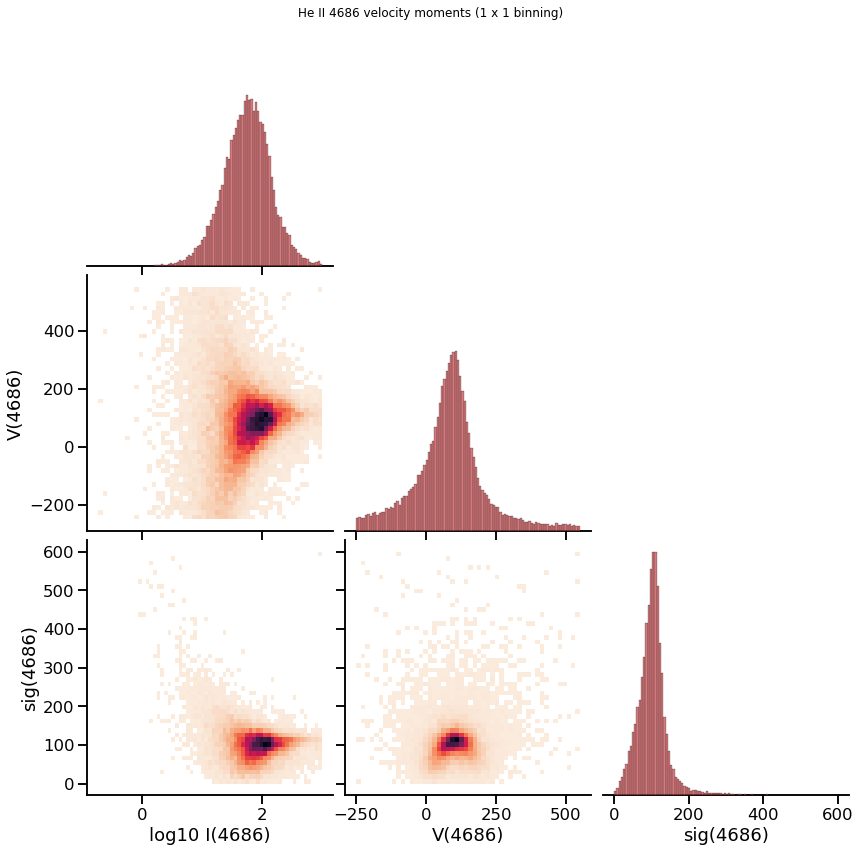

In [35]:
plot_pars_4686 = dict(
    ilabel="He II",
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)
g = moments.moments_corner_plot(
    mom4686,
    rebin=1,
    **plot_pars_4686,
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:119: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:127: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


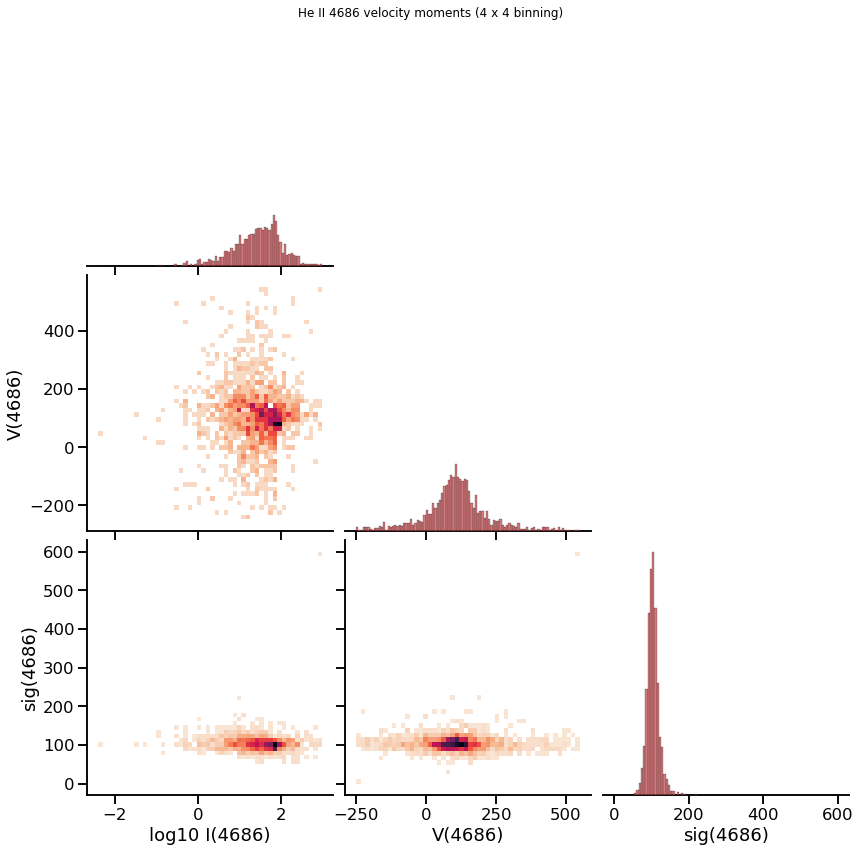

In [36]:
g = moments.moments_corner_plot(
    mom4686,
    rebin=4,
    **plot_pars_4686,
)

Unfortunately, the velocity spread does not decrease with binning, although the sigma spread does.

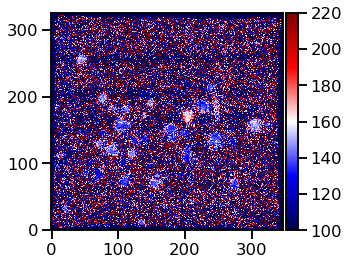

In [37]:
(3e5 * (mom4686[1] / 4685.68 - 1.0)).rebin(1).plot(
    vmin=100,
    vmax=220,
    cmap="seismic",
    colorbar="v",
)

This velocity map has serious problems with the horizontal banding. 

In [38]:
map4686 = mom4686[0].copy()
map4686.mask = map4686.mask | (map4686.data < -100)

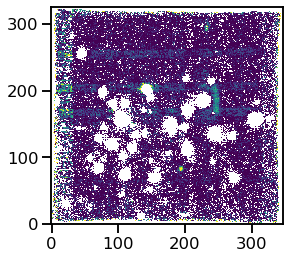

In [39]:
map4686.rebin(1).plot(
    vmin=0,
    vmax=500,
)

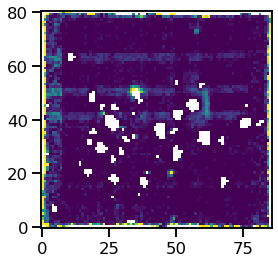

In [40]:
map4686.rebin(4).plot(
    vmin=0,
    vmax=500,
)

In [41]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=None,
    vrange=None,
    srange=None,
)
moments.save_moments_to_fits(
    mom4686,
    label="4686",
    flabel="ngc346-PZ-heii",
    **mom_pars_4686,
)

In [42]:
# ## Extract [Ar IV] line
mom4740 = moments.find_moments(csubcube.select_lambda(4740, 4746))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


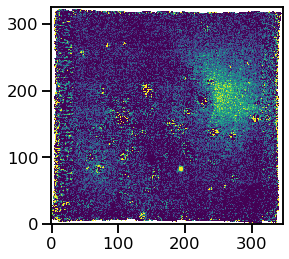

In [43]:
mom4740[0].plot(vmin=100.0, vmax=400.0)

In this case, the image is as good or better than the ESO one. Note that the minimum value is 100 since there seems to be diffuse emission over the entire map. In the ESO case, this was eliminated by definition. 

In [44]:
mom_pars_4740 = dict(
    restwav=4740.17,
    irange=[50, 1000],
    vrange=[100, 300],
    srange=[50, 150],
)

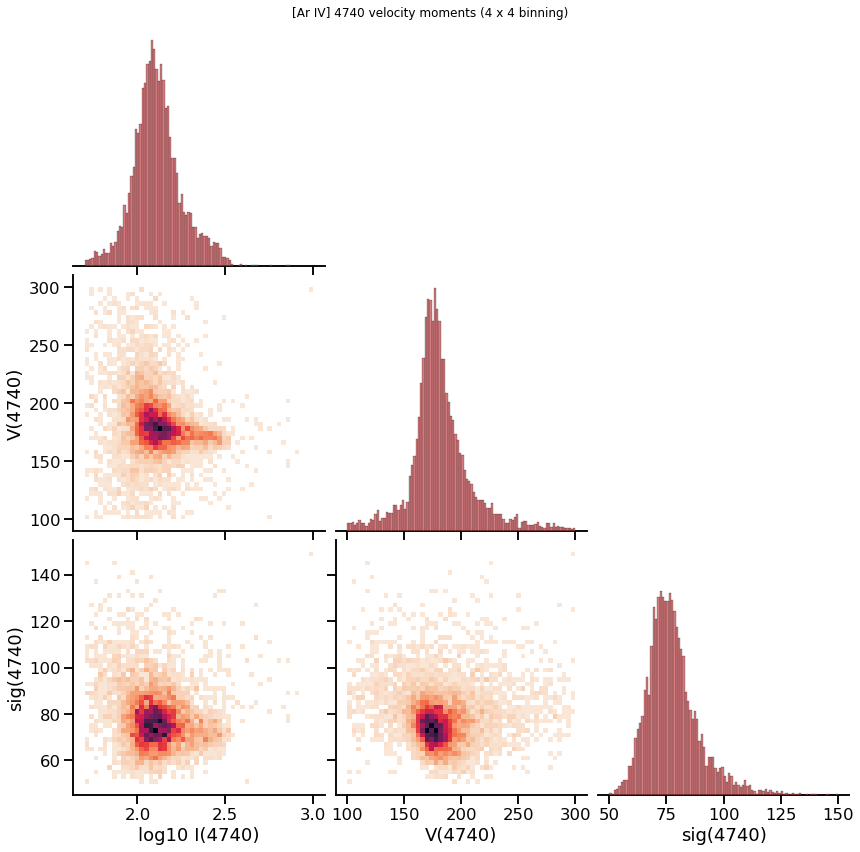

In [45]:
plot_pars_4740 = dict(
    ilabel="[Ar IV]",
    label="4740",
    flabel="ngc346-PZ-ariv",
    **mom_pars_4740,
)
g = moments.moments_corner_plot(
    mom4740,
    rebin=4,
    **plot_pars_4740,
)

These moment plots look pretty good. The velocity is well-contrained to 170 km/s in the brightest parts. It looks to be slightly redder in the fainter parts (175 to 180 km/s). 

In [46]:
moments.save_moments_to_fits(
    mom4740,
    label="4740",
    flabel="ngc346-PZ-ariv",
    restwav=4740.17,
)

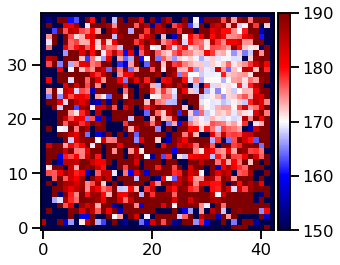

In [47]:
(3e5 * (mom4740[1] / 4740.17 - 1.0)).rebin(8).plot(
    vmin=150.0, vmax=190.0,
    cmap="seismic",
    colorbar="v",
)

This is the velocity map, which confirms that the BS seems slightly blue-shifted compared with the more diffuse [Ar IV] emission. 

And the other [Ar IV] line.  This is contaminated by He I, which we will have to sort out at some point.

In [48]:
mom4711 = moments.find_moments(csubcube.select_lambda(4711, 4717))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


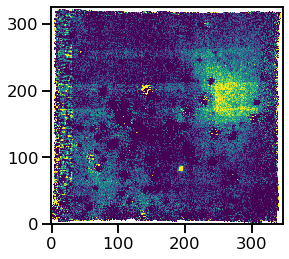

In [49]:
mom4711[0].plot(vmin=100.0, vmax=500.0)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


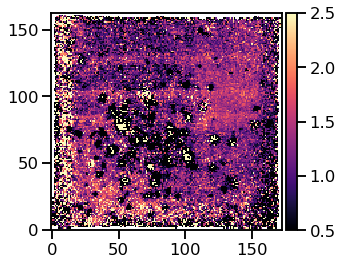

In [50]:
(mom4711[0].rebin(2) / mom4740[0].rebin(2)).plot(
    vmin=0.5,
    vmax=2.5,
    colorbar="v",
    cmap="magma",
)

So despite the contamination, the ratio is roughly constant at around 1.5 in the bright parts.

In [51]:
moments.save_moments_to_fits(
    mom4711,
    label="4711",
    flabel="ngc346-PZ-ariv",
    restwav=4711.37,
)

### Make a median-subtracted cube

So far, we have been looking at median-subtracted spectra, but have not applied the same technique to the whole cube. So I am going to try that, to see if it improves the moment maps. 

In [52]:
cmsubcube = csubcube.copy()
cmsubcube.data -= medspec_sub.data[:, None, None]

In [53]:
mom4740m = moments.find_moments(cmsubcube.select_lambda(4740, 4746))
mom4686m = moments.find_moments(cmsubcube.select_lambda(4686, 4691))
mom4711m = moments.find_moments(cmsubcube.select_lambda(4711, 4717))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


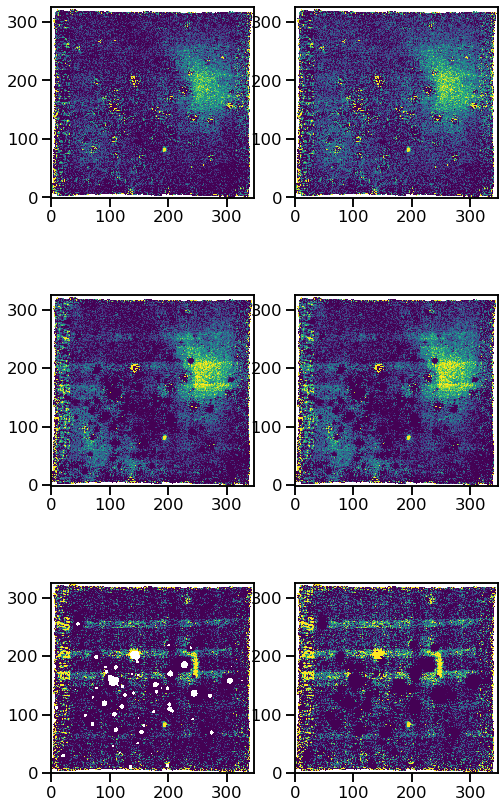

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(8, 15))
mom4740[0].plot(vmin=100, vmax=400.0, ax=axes[0, 0])
mom4740m[0].plot(vmin=-50.0, vmax=250.0, ax=axes[0, 1])
mom4711[0].plot(vmin=100, vmax=500.0, ax=axes[1, 0])
mom4711m[0].plot(vmin=-50.0, vmax=350.0, ax=axes[1, 1])
mom4686[0].plot(vmin=0, vmax=200.0, ax=axes[2, 0])
mom4686m[0].plot(vmin=0.0, vmax=200.0, ax=axes[2, 1])

So the answer is that it makes pretty much zero difference, apart from shifting the intensity baseline in some cases. 

***Verdict: Not worth pursuing for these lines, but see below where we find it makes a big improvement for [Ar III].***

### Extract super-weak [Ar III] line

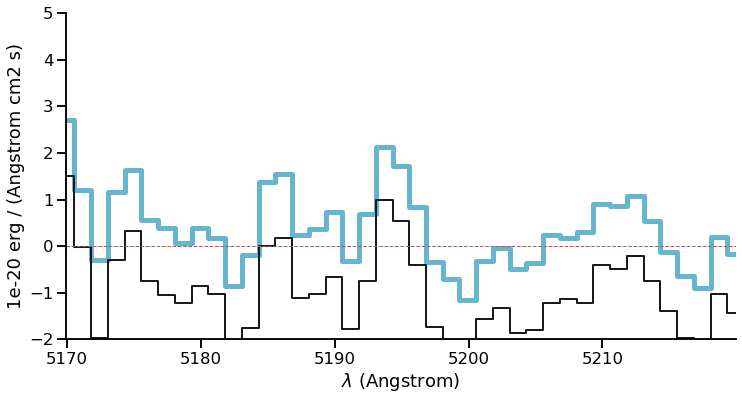

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 5170, 5220
(bowspec_sub - medspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(bowspec_sub - nobs_medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-2, 5],
)
sns.despine()

In [56]:
mom5192 = moments.find_moments(cmsubcube.select_lambda(5191, 5198))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


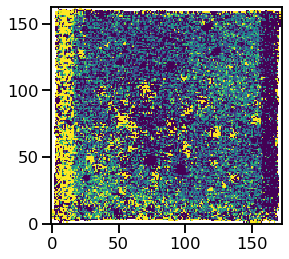

In [57]:
mom5192[0].rebin(2).plot(vmin=-20, vmax=50)

When I used the normal cube, there is nothing there at all. BUT, with the median-subtracted cube I get something very similar to what I got from the ESO pipeline cube. 

This has the classic distribution seen in medium ionization lines, where the brightest part is in the lower left. 

We do have bad artefacts in vertical strips on the left and right edges though. 

In [58]:
moments.save_moments_to_fits(
    mom5192,
    label="5192",
    flabel="ngc346-PZ-ariii",
    restwav=5191.82,
)

### Extract He I 4922

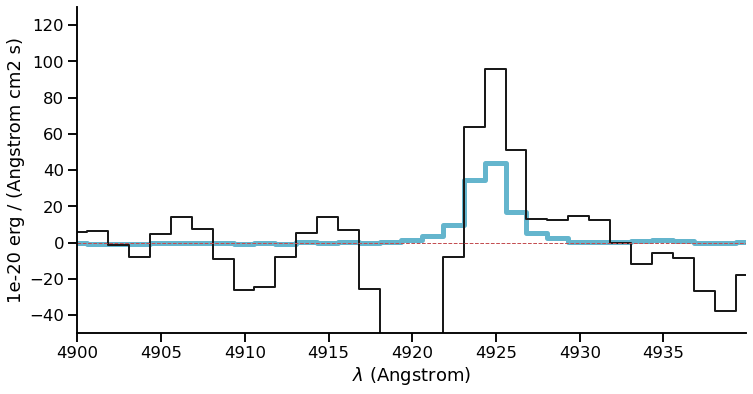

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 4900, 4940
(bowspec_sub - medspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-50, 130],
)
sns.despine()

In [60]:
mom4922 = moments.find_moments(csubcube.select_lambda(4921, 4929))
mom4922m = moments.find_moments(cmsubcube.select_lambda(4921, 4929))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


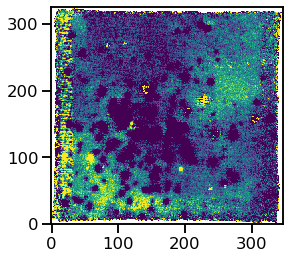

In [61]:
mom4922[0].rebin(1).plot(vmin=0.0, vmax=400.0)

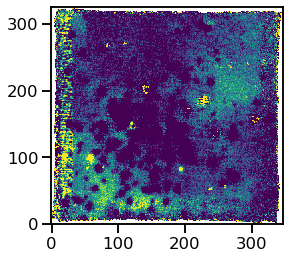

In [62]:
mom4922m[0].rebin(1).plot(vmin=-50.0, vmax=350.0)

This one is good enough signal to see the increase in brightness at the bow shock.

In [63]:
moments.save_moments_to_fits(
    mom4922,
    label="4922",
    flabel="ngc346-PZ-hei",
    restwav=4921.93,
)

### Extract He I 5048 line

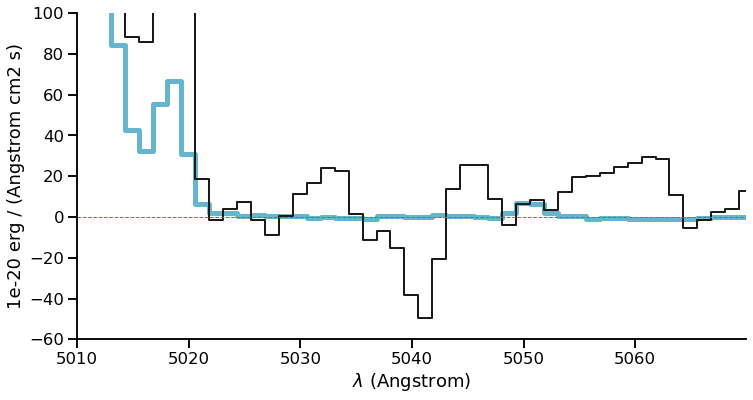

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 5010, 5070
(bowspec_sub - medspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-60, 100],
)
sns.despine()

In [65]:
mom5048 = moments.find_moments(csubcube.select_lambda(5047, 5055))
mom5048m = moments.find_moments(cmsubcube.select_lambda(5047, 5055))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


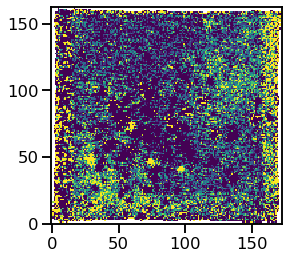

In [66]:
mom5048[0].rebin(2).plot(vmin=70.0, vmax=140.0)

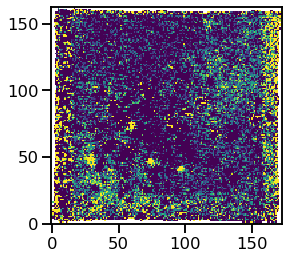

In [67]:
mom5048m[0].rebin(2).plot(vmin=0.0, vmax=70.0)

In [68]:
moments.save_moments_to_fits(
    mom5048,
    label="5048",
    flabel="ngc346-PZ-hei",
    restwav=5047.74,
)

## Extract Hβ line

In [69]:
mom4861 = moments.find_moments(csubcube.select_lambda(4859, 4869))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


Overview before correcting the sky:

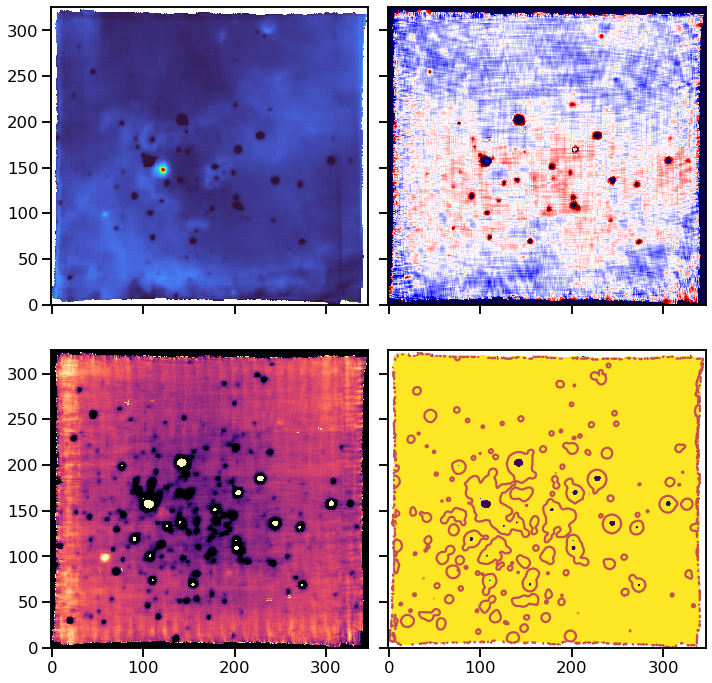

In [70]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)

imap = mom4861[0].copy()
vmap = 3e5 * (mom4861[1] / 4861.32 - 1.0)
smap = 3e5 * (mom4861[2] / 4861.32)

# m = imap.data > 10.

# vmap.mask = vmap.mask | (~m)
# smap.mask = smap.mask | (~m)

imap.rebin(1).plot(
    vmin=1e4,
    vmax=3e5,
    cmap="turbo",
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=140,
    vmax=190,
    cmap="seismic",
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=40,
    vmax=100,
    cmap="magma",
    ax=axes[1, 0],
)

imap.rebin(1).plot(
    vmin=-5000,
    vmax=0,
    cmap="viridis",
    ax=axes[1, 1],
)
bg_4861 = contcube.select_lambda(4859, 4869).mean(axis=0)
axes[1, 1].contour(
    bg_4861.data,
    levels=[1000],
    colors="r",
)

fig.tight_layout()

Make a 30 Å window:

In [71]:
core_4861 = csubcube.select_lambda(4849, 4879)

In [72]:
mom4861 = moments.find_moments(core_4861.select_lambda(4859, 4869))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


That is looking great now.  The first moment is very similat to Hα, which is encouraging.

In [73]:
mom_pars = dict(
    restwav=4861.32,
    irange=[8.0e3, 3e5],
    vrange=[150, 180],
    srange=[30, 100],
)

In [74]:
moments.save_moments_to_fits(
    mom4861,
    label="4861",
    flabel="ngc346-PZ-hi",
    **mom_pars,
)

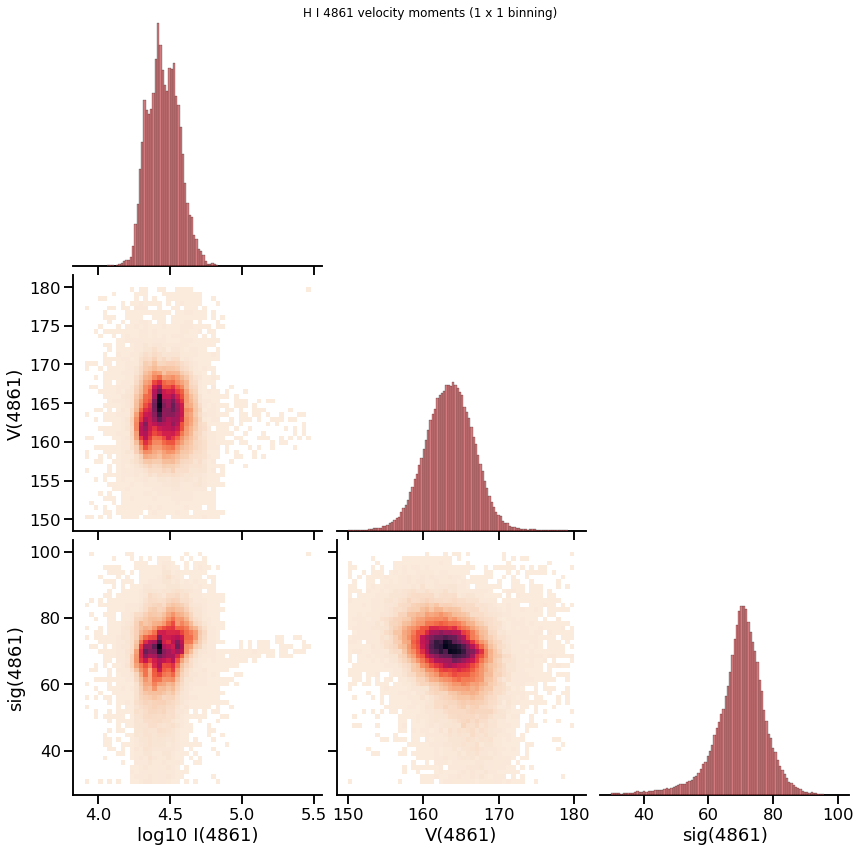

In [75]:
plot_pars = dict(
    ilabel="H I",
    label="4861",
    flabel="ngc346-hi",
    **mom_pars,
)
g = moments.moments_corner_plot(
    mom4861,
    rebin=1,
    **plot_pars,
)

This is extremely similar to the results for Ha, which is encouraging. We see the same 3 clumps on the I-V plane, and with  very similar velocities. 

The sigma is a bit larger than Ha, but that is to be expected since the instrumental broadening is larger. 